<a href="https://colab.research.google.com/github/chung-kai-eng/Eric/blob/master/Preprocessing_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing necessary dependencies

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from google.colab import drive
import tensorflow as tf
import keras
# Accessing my google drive
drive.mount("/content/drive")

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## List the file


In [0]:
!ls "/content/drive/My Drive/deep_learning/Dataset/chest-xray-pneumonia"


test  train  val



## Read file (Run in local and store the dataset as .npy)
- whether to rescale the image ( / 255.)

In [0]:
class Preprocess:
    def __init__(self, path):
        self.path = path
        self.train_dir = path + "/train"
        self.test_dir = path + "/test"
        self.val_dir = path + "/val"
        self.train_set_x = []
        self.train_set_y = []
        self.test_set_x = []
        self.test_set_y = []
        self.val_set_x = []
        self.val_set_y = []
        
    def read_file(self, path, label):
        print("path: ", path)
        # label 是一個 boolean variable，代表需不需要回傳 y 值
        image_dir = sorted(os.listdir(path))
        print(image_dir[1])
        # store the images in particular size (224, 224)
        x = np.zeros((len(image_dir), 224, 224), dtype=np.uint8)
        # print(x.shape)
        y = np.zeros((len(image_dir)), dtype=np.uint8)
        for i, file in enumerate(image_dir):
            # ,0 是直接轉為灰階
            img = cv2.imread(os.path.join(path, file), 0)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            x[i, :, :] = cv2.resize(img, (224, 224))                
            y[i] = label
        return x, y
    
    # used to get the list of all images in train, test, val
    def load_data(self, direct):   
        normal_path = ""
        pneu_path = ""
        if(direct == "train"):
            # get the directory of training set
            normal_path = self.train_dir + "/NORMAL"
            pneu_path = self.train_dir + "/PNEUMONIA"
        elif(direct == "test"):
             # get the directory of testing set
            normal_path = self.test_dir + "/NORMAL"
            pneu_path = self.test_dir + "/PNEUMONIA"
        else:
            # get the directory of validation set
            normal_path = self.val_dir + "/NORMAL"
            pneu_path = self.val_dir + "/PNEUMONIA"
        
        norm_x, norm_y = self.read_file(normal_path, 0) 
        pneu_x, pneu_y = self.read_file(pneu_path, 1) 
        data_x = np.concatenate((norm_x, pneu_x), axis = 0)
        data_y = np.concatenate((norm_y, pneu_y), axis = 0)
        # after shuffle
        np.random.shuffle(data_x)
        np.random.shuffle(data_y)
        return data_x, data_y
    
    def get_train_test_val_set(self):
        self.train_set_x, self.train_set_y = self.load_data("train")
        self.test_set_x, self.test_set_y = self.load_data("test")
        self.val_set_x, self.val_set_y = self.load_data("val")
        
        

path = "/content/drive/My Drive/deep_learning/Dataset/chest-xray-pneumonia"

model = Preprocess(path)
model.get_train_test_val_set()
# rescale the image
train = model.train_set_x / 255.
test = model.test_set_x / 255.
val = model.val_set_x / 255.

path:  /content/drive/My Drive/deep_learning/Dataset/chest-xray-pneumonia/train/NORMAL
IM-0117-0001.jpeg
path:  /content/drive/My Drive/deep_learning/Dataset/chest-xray-pneumonia/train/PNEUMONIA
person1000_virus_1681.jpeg
path:  /content/drive/My Drive/deep_learning/Dataset/chest-xray-pneumonia/test/NORMAL
IM-0003-0001.jpeg
path:  /content/drive/My Drive/deep_learning/Dataset/chest-xray-pneumonia/test/PNEUMONIA
person100_bacteria_477.jpeg
path:  /content/drive/My Drive/deep_learning/Dataset/chest-xray-pneumonia/val/NORMAL
NORMAL2-IM-1430-0001.jpeg
path:  /content/drive/My Drive/deep_learning/Dataset/chest-xray-pneumonia/val/PNEUMONIA
person1946_bacteria_4875.jpeg


In [0]:
train = np.load("/content/drive/My Drive/deep_learning/train_set.npy")
test = np.load("/content/drive/My Drive/deep_learning/test_set.npy")
val = np.load("/content/drive/My Drive/deep_learning/val_set.npy")
train_y = np.load("/content/drive/My Drive/deep_learning/train_set_y.npy")
test_y = np.load("/content/drive/My Drive/deep_learning/test_set_y.npy")
val_y = np.load("/content/drive/My Drive/deep_learning/val_set_y.npy")

In [6]:
print(train.shape)
print(test.shape)
print(val.shape)
print(train_y.shape)

(5216, 224, 224)
(624, 224, 224)
(16, 224, 224)
(5216,)


## Function for unfold and plot


In [0]:
"""
@param
    X {3-darray}: image
    mode {int}: col_mode, row_mode
@return
    unfold_X {2-darray}
"""
def unfold(X, mode):
    # the number of observation
    n = X.shape[0]
    # row shape
    p1 = X.shape[1]
    # col shape
    p2 = X.shape[2]
    # 0: column mode
    if(mode == 0):
        # let observation be last one due to we need to unfold to 2-d
        X = np.transpose(X, (1, 2, 0))
        # "F" column major
        unfold_X = np.reshape(X, [p1, n * p2], order = "F")
    # 1: row_mode
    else:
        X = np.transpose(X, (2, 1, 0))
        unfold_X = np.reshape(X, [p2, n * p1], order = "F")
    return unfold_X   
    
"""
show the plot
@param
    num {int}: the number of image we want to plot
    fig_size {tuple}: image size e.g. (8, 8)
"""
def display_img(imgs, num, fig_size):
    fig = plt.figure(figsize = fig_size)
    for i in range(num):
        ax = fig.add_subplot(np.ceil(num / 5), 5, i+1)
        ax.set_title("observation" + str(i+1)) # set the title
        ax.imshow(imgs[i], cmap = "gray", interpolation = "nearest", origin = "upper")
 


## display the unfold result

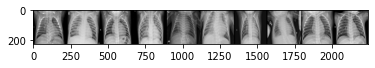

In [0]:
# dimension of image after dimension reduction
n, p1, p2 = train.shape
X_col = unfold(train, 0)
X_row = unfold(train, 1)
#print("X_col shape: ", X_col)
#print("X_row shape: ", X_row)
# check whether unfold image is successful
plt.imshow(X_col[:, 0: p2 * 10], cmap = "gray")
#plt.imshow(X_row[:, 0: p1 * 10], cmap = "gray")


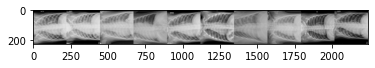

In [0]:
plt.imshow(X_row[:, 0: p1 * 10], cmap = "gray")


## Singular value decomposition
$A = U\Sigma V^T,   A^T =V\Sigma U^T$,

$A^TA=V\Sigma U^TU\Sigma V^T = V\Sigma^2V^T$

$A^TAV = V\Sigma^2$

$AA^T = U\Sigma^2 U^T$

$U\Sigma^2 U^T = U'\Sigma'V^T$

$\Sigma' = \Sigma^2,  U' = U, V' = U^T$

**Thus, eigenvector is the same between A and $AA^T$**

In [0]:
# A = U D V^T
# where U: m x m matrix, D: m x n matrix(diagonal matrix), V: n x n matrix
# U(eigenvector will be the same if we do SVD to A * A^T)
U1, D1, V1 = np.linalg.svd(X_col @ X_col.T)
U2, D2, V2 = np.linalg.svd(X_row @ X_row.T)

print("U1 shape: ", U1.shape)
print("U2 shape: ", U2.shape)

U1 shape:  (224, 224)
U2 shape:  (224, 224)


## View the eigenvalue proportion

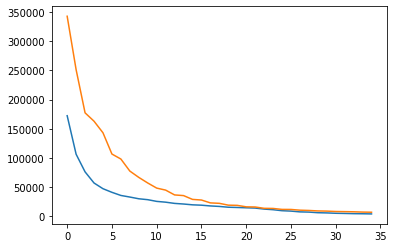

In [0]:
# There's a probability that the first eigenvalue might be too large
# Thus, we might wanna plot from the smaller one
plt.plot(D1[5:40])
plt.plot(D2[5:40])


## SVD(as the initial solution of MPCA)

In [0]:
# select the top 20 eigenvectors(most information), according to the graph shown above
q1 = 25
q2 = 25
A = U1[:, 0:q1]
B = U2[:, 0:q2]
print(A.shape)
print(B.shape)


(224, 25)
(224, 25)


## MPCA no centering (after getting initial solution of A & B matrix) 

## Compress and Reconstruct the image
**Compress the image**

$Z = A^Timage_1B$

**Reconstruct the image**

$image_1 = AA^Timage_1BB^T$
$ = A Z B^T$

In [0]:
def compare_plt(img, re_img, num, fig_size):
    fig = plt.figure(figsize = fig_size)
    for i in range(num):
        ax = fig.add_subplot(num, 2, 2*i + 1)
        ax.set_title("Original")
        ax.imshow(img[i], cmap = "gray", 
                          interpolation = "nearest", 
                          origin = "upper")

        bx = fig.add_subplot(num, 2, 2*i + 2)
        bx.set_title("Reconstruction")
        bx.imshow(re_img[i], cmap = "gray",
                             interpolation = "nearest", 
                             origin = "upper")



## ** Pay attention \**
If we want to MPCA training set, we need to set batch size; otherwise, RAM wouldn't large enough to process the data

batch_size = 500

(16, 224, 224)
AATn shape:  (16, 224, 224)
BBTn shape:  (16, 224, 224)
AATn shape:  (16, 224, 224)
BBTn shape:  (16, 224, 224)
AATn shape:  (16, 224, 224)
BBTn shape:  (16, 224, 224)
AATn shape:  (16, 224, 224)
BBTn shape:  (16, 224, 224)
AATn shape:  (16, 224, 224)
BBTn shape:  (16, 224, 224)


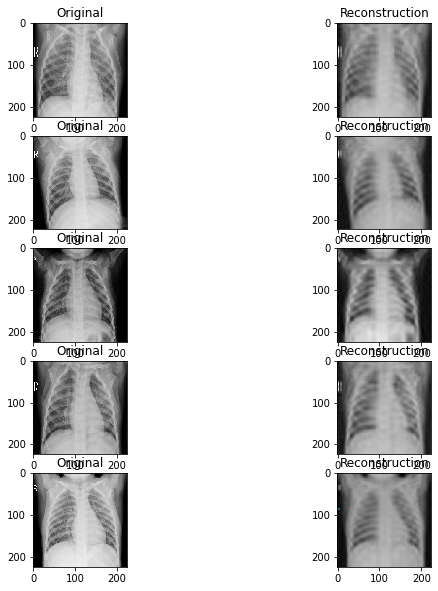

In [0]:
epoch = 5
errors = []

# store the shape to
n = val.shape[0]
p1 = val.shape[1]
p2 = val.shape[2]
x = val.copy()
recon_x = np.zeros((n, p1, p2), dtype = np.uint8)
print(x.shape)

for i in range(epoch):
    # update A
    Bn = np.expand_dims(B, 0)
    # let all images(X) multiply B(project onto eigenvectors)
    Bn = np.tile(Bn, (n, 1, 1)) # (n, p2, q2)
    XB = np.matmul(x, Bn) # (n, p1, q2)
    unfold_XB = unfold(XB, 0) # (p1, n*q2)
    U1, D1, V1 = np.linalg.svd(unfold_XB @ unfold_XB.T)
    A = U1[:, 0:q1] # core matrix(feature map)

    # update B
    ATn = np.expand_dims(A.T, 0)
    ATn = np.tile(ATn, (n, 1, 1)) # (n, q1, p1)
    XA = np.matmul(ATn, x) # (n, q1, p2)
    unfold_XA = unfold(XA, 1) # (p2, n * q1)
    U2, D2, V2 = np.linalg.svd(unfold_XA @ unfold_XA.T)
    B = U2[:, 0:q2] # core matrix

    # compute reconstruction error
    AATn = np.expand_dims(A @ A.T, 0)
    AATn = np.tile(AATn, [n, 1, 1])
    BBTn = np.expand_dims(B @ B.T, 0)
    BBTn = np.tile(BBTn, [n, 1, 1])
    print("AATn shape: ", AATn.shape)
    print("BBTn shape: ", BBTn.shape)
    recon_x = AATn @ x @ BBTn
    # np.sum( , axis = 1) --> summation of row
    # np.sum(np.sum( , axis = 1)) --> summation of row and col(one image)
    error = np.sum(np.sum((x - recon_x) ** 2, axis = 1), axis = 1)
    #print(error)
    errors.append(np.mean(error))
compare_plt(x, recon_x, 5, (10, 10))
plt.plot(errors)

In [0]:
"""
@param
    X {3-darray}: image
    mode {int}: col_mode, row_mode
@return
    unfold_X {2-darray}
"""
def unfold_batch(X, mode, batch_size):
    # the number of observation
    n = batch_size
    # row shape
    p1 = X.shape[1]
    # col shape
    p2 = X.shape[2]
    # 0: column mode
    if(mode == 0):
        # let observation be last one due to we need to unfold to 2-d
        X = np.transpose(X, (1, 2, 0))
        # "F" column major
        unfold_X = np.reshape(X, [p1, n * p2], order = "F")
    # 1: row_mode
    else:
        X = np.transpose(X, (2, 1, 0))
        unfold_X = np.reshape(X, [p2, n * p1], order = "F")
        #print("unfold_X.shape: ", unfold_X)
    return unfold_X   

In [0]:
batch_size = 500
epoch = 5
n = train.shape[0]
x = train.copy()
errors_list = []
for i in range(epoch):
    errors = []
    for num in range(int(n / batch_size)):
        sub_x = x[num * batch_size:(num + 1)* batch_size]
        #print(sub_x.shape)
        # update A
        Bn = np.expand_dims(B, 0)
        # let all images(X) multiply B(project onto eigenvectors)
        Bn = np.tile(Bn, (batch_size, 1, 1)) # (n, p2, q2)
        XB = np.matmul(sub_x, Bn) # (n, p1, q2)
        unfold_XB = unfold_batch(XB, 0, batch_size) # (p1, n*q2)
        U1, D1, V1 = np.linalg.svd(unfold_XB @ unfold_XB.T)
        A = U1[:, 0:q1] # core matrix(feature map)

        # update B
        ATn = np.expand_dims(A.T, 0)
        ATn = np.tile(ATn, (batch_size, 1, 1)) # (n, q1, p1)
        XA = np.matmul(ATn, sub_x) # (n, q1, p2)
        unfold_XA = unfold_batch(XA, 1, batch_size) # (p2, n * q1)
        U2, D2, V2 = np.linalg.svd(unfold_XA @ unfold_XA.T)
        B = U2[:, 0:q2] # core matrix

        # compute reconstruction error
        AATn = np.expand_dims(A @ A.T, 0)
        AATn = np.tile(AATn, [batch_size, 1, 1])
        BBTn = np.expand_dims(B @ B.T, 0)
        BBTn = np.tile(BBTn, [batch_size, 1, 1])
        #print("AATn shape: ", AATn.shape)
        #print("BBTn shape: ", BBTn.shape)
        recon_x = AATn @ sub_x @ BBTn
        # np.sum( , axis = 1) --> summation of row
        # np.sum(np.sum( , axis = 1)) --> summation of row and col(one image)
        error = np.sum(np.sum((sub_x - recon_x) ** 2, axis = 1), axis = 1)
        errors.append(np.mean(error))
    errors_list.append(np.mean(errors))


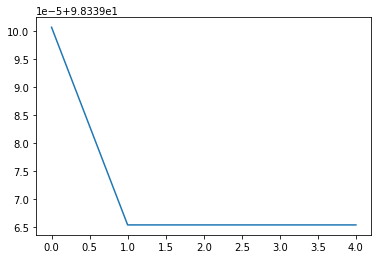

In [0]:
plt.plot(errors_list)
compare_plt()

In [0]:
x = train.copy()
x[1:200].shape

(199, 224, 224)

## Show the basis plot

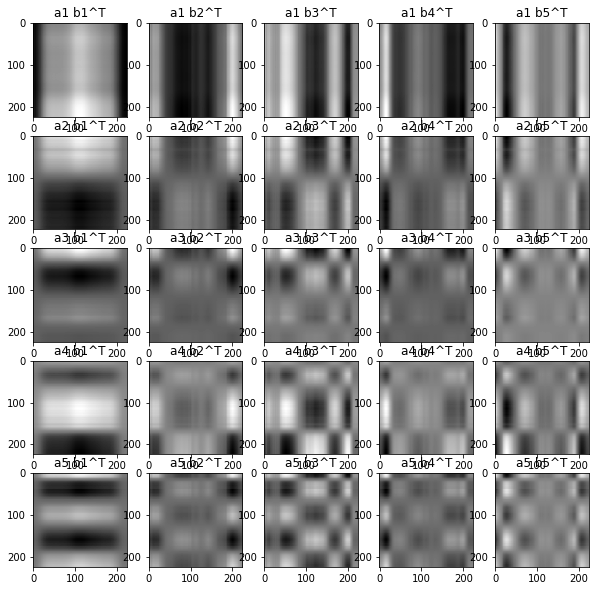

In [0]:
# basis plot on validation image
def display_basis_plt(A, B, num, fig_size):
    fig = plt.figure(figsize = fig_size)
    for i in range(num):
        for j in range(num):
            ax = fig.add_subplot(num, num, i * num + j + 1)
            ax.set_title("a{} b{}^T".format(i + 1, j + 1))
            ai = A[:, i:(i+1)]
            bi = B[:, j:(j+1)]
            img = ax.imshow(ai @ bi.T, cmap = "gray", 
                            interpolation = "nearest", 
                            origin = "upper")

display_basis_plt(A, B, 5, (10, 10))

## check one image shape and display the image

image_shape:  (1858, 2090)
(299, 168, 3)


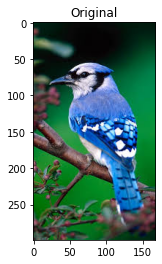

(3, 299, 168)
(299, 504)


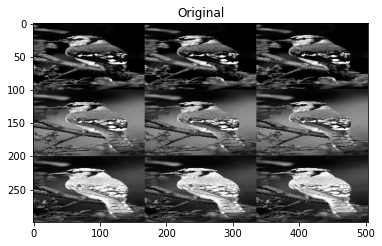

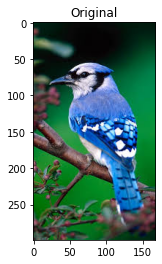

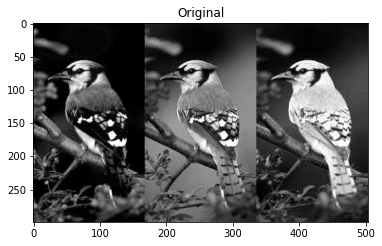

In [0]:
# print one image's shape to check
path = "/content/drive/My Drive/deep_learning/Dataset/chest-xray-pneumonia/train/NORMAL/IM-0115-0001.jpeg"
from PIL import Image
k = Image.open(path)
k_in = np.asarray(k, dtype = np.uint8)
print("image_shape: ", k_in.shape)

def display_image(img, title = "Original"):
  plt.imshow(img, cmap = "gray")
  plt.title(title)
  plt.show()

path = "/content/drive/My Drive/deep_learning/Dataset/train/bird1.jpg"
k = Image.open(path)
k = np.asarray(k, dtype = np.uint8)

img = k
print(img.shape)
p1 = img.shape[0]
p2 = img.shape[1]
p3 = img.shape[2]
display_image(img)

img_1 = np.transpose(img, (2, 0, 1))
print(img_1.shape)
#display_image(img_1)
img_2 = np.reshape(img_1, [p1, p2 * p3])
print(img_2.shape)
display_image(img_2)

img_3 = np.transpose(img, (0, 1, 2))
display_image(img_3)
img_4 = np.reshape(img_3, [p1, p2 * p3], order = "F")
display_image(img_4)

## PCA decomposition

pca factor:  [0.20259088678371723, 0.12873891720407327, 0.052179956725188416, 0.03747596368218394, 0.03268862410218972, 0.022312561667811964, 0.01964730852212823]
train shape:  (224, 224)
pca train shape:  (224, 10)


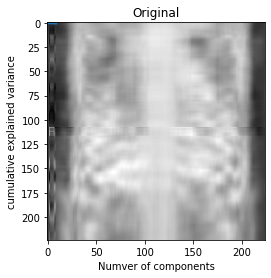

In [0]:
from sklearn.decomposition import PCA

# arbitrarily decide # of components
pca = PCA(n_components = 10)
pca.fit(model.train_set_x[1])

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Numver of components")
plt.ylabel("cumulative explained variance")

pca_factor = sorted(pca.explained_variance_ratio_, reverse = True)
print("pca factor: ", pca_factor[1:8])



"""
if the upper code is OK, then execute the rest of code
still need to solve the high dimension problem
whether to do pca one image to one image to train or for all?
If all, then how to do?
"""
X_pca_train = pca.fit_transform(train[1])
X_pca_test = pca.fit_transform(test[1])
X_pca_val = pca.fit_transform(val[1])

print("train shape: ", train[1].shape)
print("pca train shape: ", X_pca_train.shape)
# reconstruct the image (PCA decomposition can be inverted)
inv_pca = pca.inverse_transform(X_pca_train)
display_image(inv_pca.reshape(224, 224))

In [0]:

path = "/content/drive/My Drive/deep_learning/Dataset/chest-xray-pneumonia/NORMAL/test"
normal_path = path + "/NORMAL"
pneu_path = path + "/PNEUMONIA"

def readfile(path, label):
    print("path: ", path)
    # label 是一個 boolean variable，代表需不需要回傳 y 值
    image_dir = sorted(os.listdir(path))
    print(image_dir[1])
    # store the images in particular size (224, 224)
    x = np.zeros((len(image_dir), 224, 224, 3), dtype=np.uint8)
    print(x.shape)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
      #  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        x[i, :, :] = cv2.resize(img, (224, 224))
    return x

train_set = readfile(normal_path, False)

path:  /content/drive/My Drive/deep_learning/Dataset/chest-xray-pneumonia/NORMAL/test/NORMAL


FileNotFoundError: ignored

In [0]:
print(train_set[1])


[[[ 40  40  40]
  [ 36  36  36]
  [ 30  30  30]
  ...
  [111 111 111]
  [118 118 118]
  [104 104 104]]

 [[ 39  39  39]
  [ 33  33  33]
  [ 31  31  31]
  ...
  [124 124 124]
  [112 112 112]
  [109 109 109]]

 [[ 38  38  38]
  [ 37  37  37]
  [ 34  34  34]
  ...
  [115 115 115]
  [111 111 111]
  [106 106 106]]

 ...

 [[ 40  40  40]
  [ 41  41  41]
  [ 43  43  43]
  ...
  [ 34  34  34]
  [ 33  33  33]
  [ 35  35  35]]

 [[ 41  41  41]
  [ 39  39  39]
  [ 39  39  39]
  ...
  [ 31  31  31]
  [ 32  32  32]
  [ 34  34  34]]

 [[ 36  36  36]
  [ 40  40  40]
  [ 38  38  38]
  ...
  [ 29  29  29]
  [ 32  32  32]
  [ 31  31  31]]]


## Display Image

In [0]:
def display_multiple_img():
   pass
def display_image(img, title = "Original"):
  plt.imshow(img)
  plt.title(title)
  plt.show()

## Preprocessing the images
- read image
- resize image
- remove noise
- Segmentation
- Morphology(smoothing edges)

In [0]:
# Preprocessing
def processing(data):
    
    # Reading 3 images to work
    img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in data[:3]]
    try:
        print('Original size',img[0].shape)
    except AttributeError:
        print("shape not found")
   
    # --------------------------------
    # setting dim of the resize
    height = 220
    width = 220
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Checcking the size
    try:
        print('RESIZED', res_img[1].shape)
    except AttributeError:
        print("shape not found")
    
    
    # Visualizing one of the images in the array
    original = res_img[1]
    display_one(original)
    # ----------------------------------
    # Remove noise
    # Using Gaussian Blur
    no_noise = []
    for i in range(len(res_img)):
        blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
        no_noise.append(blur)


    image = no_noise[1]
    display(original, image, 'Original', 'Blured')
    #---------------------------------
    # Segmentation
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Displaying segmented images
    display(original, thresh, 'Original', 'Segmented')
    # Further noise removal (Morphology)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    #Displaying segmented back ground
    display(original, sure_bg, 'Original', 'Segmented Background')

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]

    # Displaying markers on the image
    display(original, markers, 'Original', 'Marked')

In [0]:
!pip install -q keras

In [0]:
import keras

Using TensorFlow backend.


## Image directory

In [0]:
train_path = "/content/drive/My Drive/deep_learning/Dataset/train"
def readfile(path, label):
    # label 是一個 boolean variable，代表需不需要回傳 y 值
    image_dir = sorted(os.listdir(path))
    print(image_dir)
    x = np.zeros((len(image_dir), 224, 224, 3), dtype=np.uint8)
    print(x.shape)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        print("i: ", i)
        img = cv2.imread(os.path.join(path, file))
      #  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        x[i, :, :] = cv2.resize(img, (224, 224))
        if label:
          y[i] = int(file.split("_")[0])
    print(y[0])
    if label:
      return x, y
    else:
      return x
train_img = readfile(train_path, False)

['bird1.jpg', 'bird2.jpg', 'bird3.jpg', 'bird4.jpg']
(4, 224, 224, 3)
i:  0
i:  1
i:  2
i:  3
0


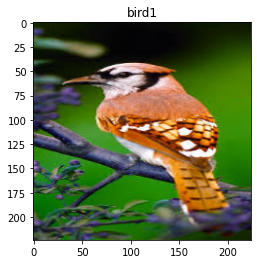

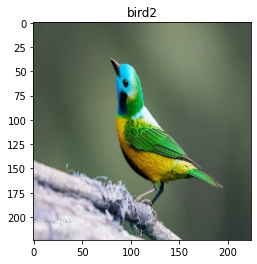

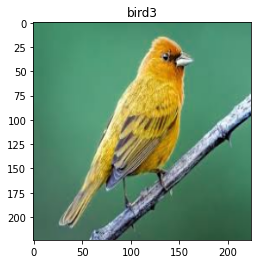

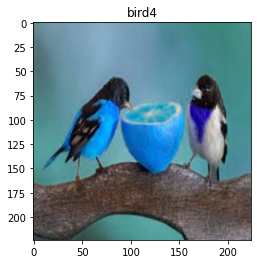

In [0]:
count = 1
for i in train_img:
  title = "bird" + str(count)
  display_image(img = i, title = title)
  count += 1

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/deep_learning/DataSet/chest-xray-pneumonia.zip", 'r')

FileNotFoundError: ignored

In [0]:
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

# download the mnist to the path '~/.keras/datasets/' if it is the first time to be called
# training X shape (60000, 28x28), Y shape (60000, ). test X shape (10000, 28x28), Y shape (10000, )
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# data pre-processing
train_X = X_train.reshape(-1, 28, 28, 1)/255.
test_X = X_test.reshape(-1, 28, 28, 1)/255.
train_Y = np_utils.to_categorical(y_train, num_classes=10)
test_Y = np_utils.to_categorical(y_test, num_classes=10)


11493376/11490434 [==============================] - 0s 0us/step


array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

## Read file

In [0]:
# defining global variable path
# Location of my dataset on My Google Drive
path = "/content/drive/My Drive/deep_learning/Dataset/chest-xray-pneumonia"
def readfile(path, label):
    # label 是一個 boolean variable，代表需不需要回傳 y 值
    image_dir = sorted(os.listdir(path))
    print(image_dir)
    # store the images in particular size (224, 224)
    x = np.zeros((len(image_dir), 224, 224, 3), dtype=np.uint8)
    print(x.shape)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        print("i: ", i)
        img = cv2.imread(os.path.join(path, file))
      #  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        x[i, :, :] = cv2.resize(img, (224, 224))
        if label:
          y[i] = int(file.split("_")[0])
    print(y[0])
    if(label):
      return x, y
    else:
      return x

train_set



NameError: ignored